In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
from Backtesting import *

In [6]:
directory = "O:/AARM/Direct/Top Holdings/Research/Biotech/NW/"

bt_data = BacktesterData(
    holdings_path=directory + 'Output/holdings.csv',
    sec_master_path=directory + 'Output/security_master.csv',
    sec_mapping_path=directory + 'Output/security_mapping.csv',
    sec_out_path=directory + 'Output/security_out.csv',
    managers_path=directory + 'Input/managers.xlsx'
)

In [9]:
bt = FilingBacktester(bt_data)

# Set pandas option to suppress the FutureWarning about downcasting
import pandas as pd
pd.set_option('future.no_silent_downcasting', False)


In [10]:
consolidated_error_df = bt_data.error_df.groupby(['Ticker', 'Name']).agg({
    'holding_date': ['min', 'max'],
    'value': 'sum'
}).reset_index()
consolidated_error_df.columns = ['Ticker', 'Name', 'min_holding_date', 'max_holding_date', 'value']
consolidated_error_df = consolidated_error_df.sort_values('value', ascending=False)

# Exclude securities I have already verified are from erroneus filings
excluded_tickers = ['SVA US', #Private, reported holdings values are stale
                    'DCPH US', #Acquired
                    'BLU CN', #Acquired
                    'ZGNX US', #Acquired
                    '1284849DUS', #Acquired
                    'ALPN US', #Acquired
                    'PRXL US', #Delisted
                    'QP/ LN', #Private
                    ]
consolidated_error_df = consolidated_error_df[~consolidated_error_df['Ticker'].isin(excluded_tickers)]

print("Top errors by value:")
# Set display options to show more rows
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
print(consolidated_error_df)

Top errors by value:
        Ticker                                          Name min_holding_date max_holding_date  \
58     VYNE US                        VYNE Therapeutics Inc.       2014-12-31       2017-12-31   
35     NEUP US                   Neuphoria Therapeutics Inc.       2017-06-30       2021-09-30   
60     ZCOR US                            Zyla Life Sciences       2014-12-31       2018-12-31   
2   1891847DUS                 Centrexion Therapeutics Corp.       2018-03-31       2024-12-31   
56     VRNA US                             Verona Pharma plc       2014-12-31       2017-03-31   
47     SLGC US                      CM Life Sciences II Inc.       2021-03-31       2021-03-31   
23     FLAC US  Frazier Lifesciences Acquisition Corporation       2020-12-31       2020-12-31   
39    PRGBQ US                Protea Biosciences Group, Inc.       2021-12-31       2022-03-31   
19     CERE US             ARYA Sciences Acquisition Corp II       2020-06-30       2020-06-30   

In [11]:
mkt_cap = bt.sec_mkt_cap_df
eligible = bt.eligible_securities_df
rets = bt.sec_rets_df
valid_rets = (rets == 0).sum(axis=1) < 0.9*len(rets.columns)
mkt_cap = mkt_cap.multiply(eligible)
mkt_cap = mkt_cap.replace(0, np.nan)
mkt_cap = mkt_cap.loc[valid_rets]
rets = rets.loc[valid_rets]

# Size
size_score = np.log(mkt_cap)
size_score = bt.standardize_factor_scores(size_score).shift(1)

# Separate Reversal (short-term) and Momentum (long-term) factors
MOMENTUM_LONG_PERIOD = 252 #~1 year
REVERSAL_PERIOD = 21 #~1 month

# Long-term momentum component
# Calculate returns excluding the most recent REVERSAL_PERIOD (21 days)
# and including only the period from t-MOMENTUM_LONG_PERIOD to t-REVERSAL_PERIOD
momentum_score = np.log(rets+1).shift(REVERSAL_PERIOD).rolling(window=MOMENTUM_LONG_PERIOD-REVERSAL_PERIOD, min_periods=63).mean().fillna(0)
momentum_score = bt.standardize_factor_scores(momentum_score).shift(1)

# Short-term reversal component (negative of short-term returns)
reversal_score = -np.log(rets+1).ewm(halflife=REVERSAL_PERIOD, adjust=True).mean().fillna(0)
reversal_score = bt.standardize_factor_scores(reversal_score).shift(1)

factor_scores = {'Size': size_score, 'Momentum': momentum_score, 'Reversal': reversal_score}
factor_rets = bt.get_factor_returns(factor_scores)

Error fitting model for 2010-01-05 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-06 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-07 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-08 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-11 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-12 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-13 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-14 00:00:00: zero-size array to reduction operation maximum which has no identity
Error fitting model for 2010-01-15 00:00:00: zero-size array to reduction operation maxi

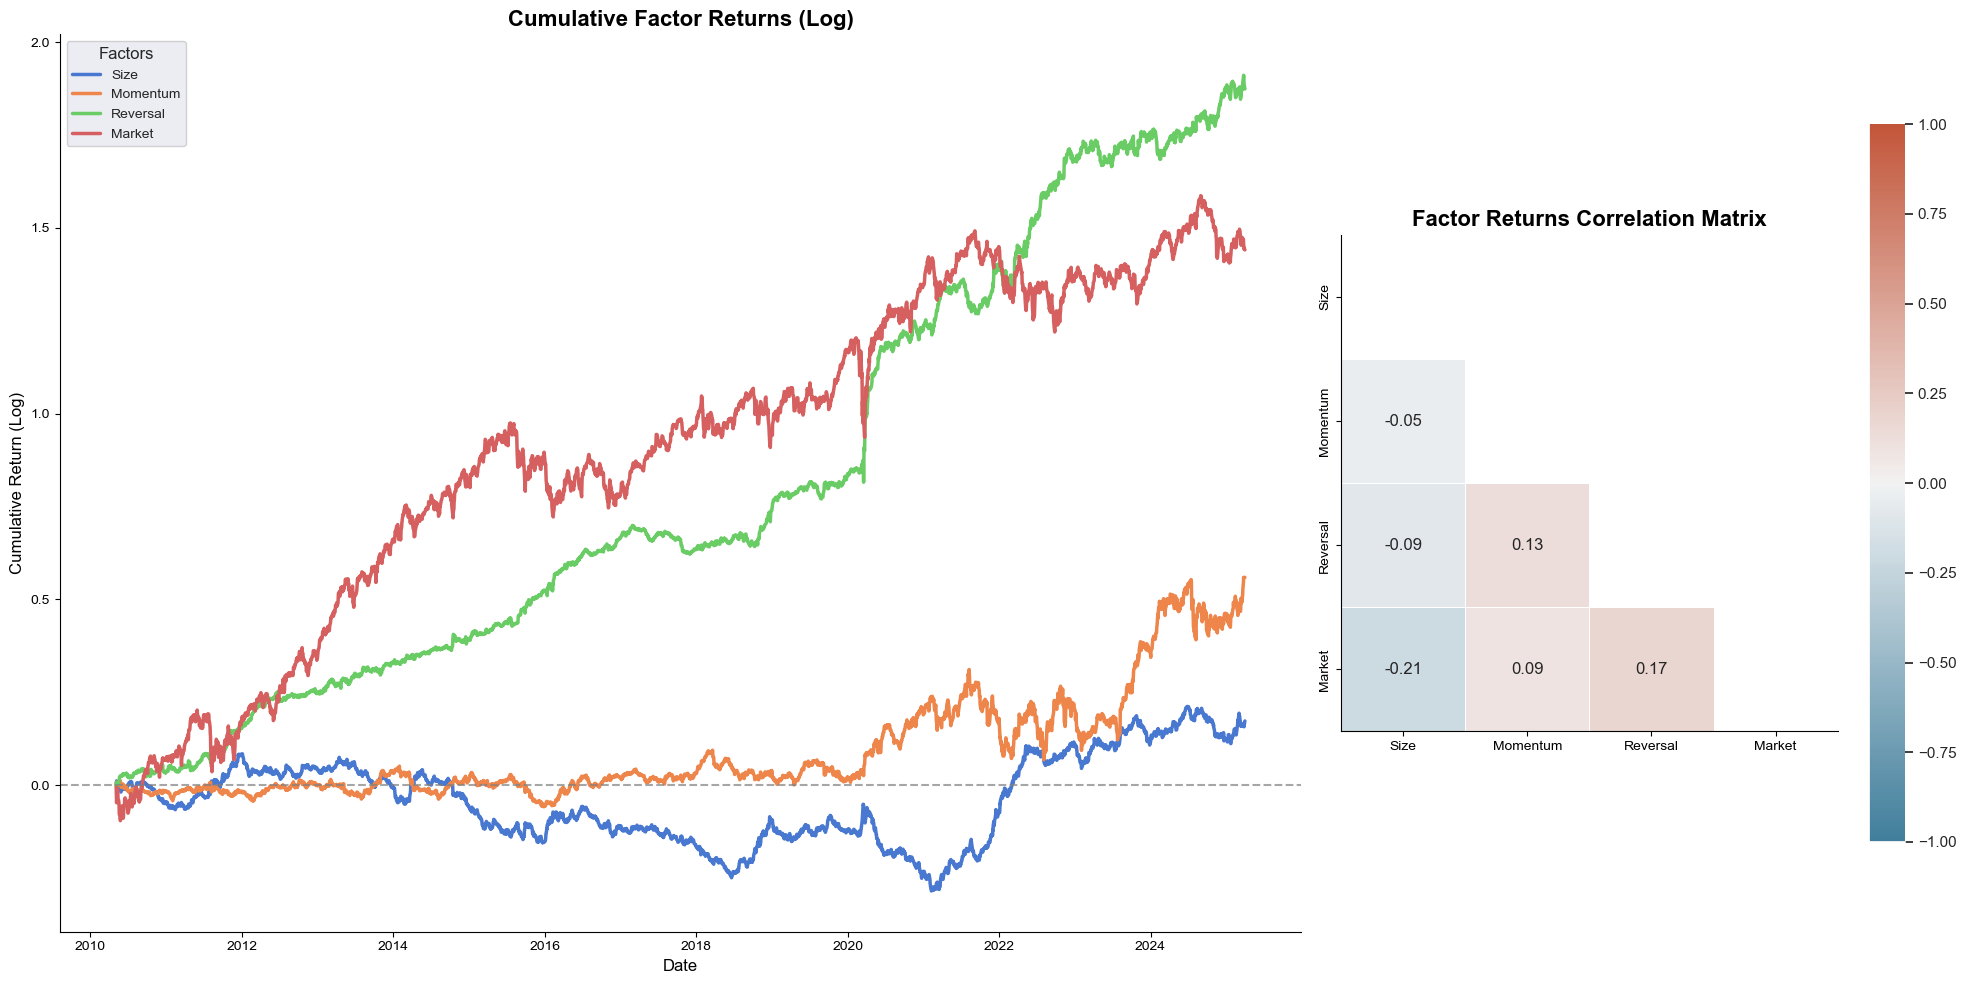

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

factor_rets_filtered = factor_rets.dropna(how='all')
factor_rets_clean = factor_rets_filtered.fillna(0)
cum_factor_rets = np.log(1 + factor_rets_clean).cumsum()

# Create a figure with side-by-side subplots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Set the seaborn style
sns.set_theme(style="darkgrid")

# Plot 1: Cumulative Factor Returns
sns.lineplot(data=cum_factor_rets, dashes=False, linewidth=2.5, palette="muted", ax=ax1)

# Enhance the plot with better formatting
ax1.set_title('Cumulative Factor Returns (Log)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Cumulative Return (Log)', fontsize=12)
ax1.legend(title='Factors', title_fontsize=12, fontsize=10, frameon=True, framealpha=0.9)

# Add a zero line for reference
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)

# Plot 2: Factor Return Correlations
corr_matrix = factor_rets_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax2)

ax2.set_title('Factor Returns Correlation Matrix', fontsize=16, fontweight='bold')

# Format the plots
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()

In [136]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

HALF_LIFE = 365*2
MIN_PCT = 0.001
MIN_MV = 1

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2024-12-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)
quarter_ends_delayed = quarter_ends + pd.DateOffset(days=45)  # Convert to DatetimeIndex instead of list
future_idio_returns = bt.get_period_idio_returns(factor_scores, factor_rets, dates=quarter_ends_delayed).shift(-1) #shift back one quarter to align with fund holdings

calendar_quarter_total_returns = bt.get_period_returns(dates=quarter_ends).shift(-1) #shift back one quarter to align with fund holdings
calendar_quarter_total_returns.index = calendar_quarter_total_returns.index + pd.DateOffset(days=45)

quarter_ends_and_filing_dates = pd.DatetimeIndex(quarter_ends_delayed.union(quarter_ends)).sort_values()
pre_filing_idio_returns = bt.get_period_idio_returns(factor_scores, factor_rets, dates=quarter_ends_and_filing_dates)
pre_filing_idio_returns = pre_filing_idio_returns.reindex(index=quarter_ends_delayed)

#fund_list = bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna())]['Master'].unique()# | bt.manager_df['Contamination'] | bt.manager_df['Not_Biotech'])]['Master'].unique()
fund_list = bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna())]['Master'].unique()
fund_holdings_long = {}
fund_holdings_wide = {}
fund_start_date = {}
fund_end_date = {}

for fund in fund_list:
    holdings = bt.get_fund_holdings(fund)   
    holdings.index = holdings.index + pd.Timedelta(days=45)

    holdings_mv = bt.get_fund_holdings(fund, normalize=False)
    holdings_mv.index = holdings_mv.index + pd.Timedelta(days=45)

    if(len(holdings) == 0):
        print(f"{fund} has no holdings")
        fund_list = fund_list[fund_list != fund]
        continue

    fund_holdings_wide[fund] = holdings.reindex(index=quarter_ends_delayed, columns=future_idio_returns.columns).fillna(0)
    fund_start_date[fund] = holdings.index[0]
    fund_end_date[fund] = holdings.index[-1]

    idio = future_idio_returns.reindex(index=holdings.index, columns=holdings.columns).stack()
    idio.name = 'idio_returns'

    pre_filing_idio = pre_filing_idio_returns.reindex(index=holdings.index, columns=holdings.columns).stack()
    pre_filing_idio.name = 'pre_filing_idio_returns'

    holdings_ownership = holdings_mv.div(bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns))
    holdings_ownership = holdings_ownership.stack()
    holdings_ownership.name = 'holdings_ownership'

    holdings_ownership_chg = holdings_mv.div(bt.sec_mkt_cap_df.reindex(index=holdings.index, columns=holdings.columns)).diff()
    holdings_ownership_chg = holdings_ownership_chg.stack()
    holdings_ownership_chg.name = 'holdings_ownership_chg'

    holdings_chg = holdings_mv.mul(calendar_quarter_total_returns.reindex(index=holdings.index, columns=holdings.columns) + 1).shift(1).fillna(0)
    holdings_chg = holdings_chg.div(holdings_chg.sum(axis=1), axis=0)
    holdings_chg = holdings.sub(holdings_chg)
    holdings_chg = holdings_chg.stack()
    holdings_chg.name = 'holdings_chg'

    holdings_mv = holdings_mv.stack()
    holdings_mv = holdings_mv[holdings_mv > MIN_MV]  # Drop small holdings after stack
    holdings_mv.name = 'holdings_mv'

    holdings = holdings.stack()
    holdings = holdings[holdings > MIN_PCT]  # Drop small holdings after stack
    holdings.name = 'holdings'

    holdings = pd.merge(holdings, holdings_mv, left_index=True, right_index=True, how='inner')
    holdings = pd.merge(holdings, holdings_chg, left_index=True, right_index=True, how='left') 
    holdings = pd.merge(holdings, holdings_ownership, left_index=True, right_index=True, how='left')
    holdings = pd.merge(holdings, holdings_ownership_chg, left_index=True, right_index=True, how='left')
    holdings = pd.merge(holdings, pre_filing_idio, left_index=True, right_index=True, how='left')
    holdings = pd.merge(holdings, idio, left_index=True, right_index=True, how='left')
    holdings = holdings.drop('holdings_mv', axis=1)

    fund_holdings_long[fund] = holdings



Point72 has no holdings


In [138]:
print(fund_holdings_long['RA'].head())

                         holdings  holdings_chg  holdings_ownership  holdings_ownership_chg  \
holding_date Ticker                                                                           
2015-02-14   1893407DUS  0.106423           NaN            0.067144                     NaN   
             AGIO US     0.002557           NaN            0.000454                     NaN   
             AKBA US     0.009016           NaN            0.036678                     NaN   
             ALKS US     0.001458           NaN            0.000108                     NaN   
             ARAV US     0.006732           NaN            0.009858                     NaN   

                         pre_filing_idio_returns  idio_returns  
holding_date Ticker                                             
2015-02-14   1893407DUS                -0.154004     -0.259117  
             AGIO US                   -0.000527     -0.164602  
             AKBA US                   -0.297366     -0.264605  
         

In [139]:
fund_predictions = {}

for fund in fund_list:
    fund_predictions[fund] = pd.DataFrame()
    
    for date in quarter_ends_delayed:

        if date <= fund_start_date[fund] or (date > fund_end_date[fund]+pd.Timedelta(days=45)):
            continue
         
        # Get historical data
        hist_fund_long = fund_holdings_long[fund].loc[fund_holdings_long[fund].index.get_level_values(0) < date].copy()
        hist_fund_long = hist_fund_long.dropna(subset=['idio_returns', 'holdings', 'holdings_ownership'])
        hist_fund_long = hist_fund_long.fillna(0)

        # Get current data
        cur_fund_long = fund_holdings_long[fund].loc[fund_holdings_long[fund].index.get_level_values(0) == date].copy()
        cur_fund_long = cur_fund_long.reset_index(level=0, drop=True)

        # Calculate exponential weights
        dates = hist_fund_long.index.get_level_values(0).unique()
        exp_weights = (date - dates).days
        exp_weights = np.exp(-np.log(2) * (exp_weights) / HALF_LIFE)
        exp_weights = pd.Series(exp_weights, index=dates)
        exp_weights = exp_weights / exp_weights.sum()

        # Apply weights
        date_to_weight = exp_weights.to_dict()
        hist_fund_long['weight'] = hist_fund_long.index.get_level_values(0).map(date_to_weight)

        # Calculate log values safely
        for df in [hist_fund_long, cur_fund_long]:
            df['log_holdings'] = np.log10(df['holdings'].clip(lower=1e-10))
            df['log_ownership'] = np.log10(df['holdings_ownership'].clip(lower=1e-10))

        # Standardize features
        for col in ['log_holdings', 'log_ownership', 'holdings_chg', 'holdings_ownership_chg', 'pre_filing_idio_returns' ,'idio_returns']:
            # Combine datasets
            combined = pd.concat([hist_fund_long[col], cur_fund_long[col]])
            
            # First standardization using robust statistics
            median = combined.median()
            robust_std_dev = 1.4826 * (combined.sub(median).abs().median())
            if robust_std_dev == 0:
                robust_std_dev = 1.0
            combined = combined.sub(median).div(robust_std_dev)
            
            # Second standardization using mean/std
            mean = combined.mean()
            std_dev = combined.std()
            if std_dev == 0:
                std_dev = 1.0
            
            # Apply standardization to original datasets
            hist_fund_long[col] = hist_fund_long[col].sub(median).div(robust_std_dev).sub(mean).div(std_dev)
            cur_fund_long[col] = cur_fund_long[col].sub(median).div(robust_std_dev).sub(mean).div(std_dev)
            
            # Clip extreme values
            hist_fund_long[col] = hist_fund_long[col].clip(lower=-3, upper=3)
            cur_fund_long[col] = cur_fund_long[col].clip(lower=-3, upper=3)

            # Fill NaN values
            hist_fund_long[col] = hist_fund_long[col].fillna(0)
            cur_fund_long[col] = cur_fund_long[col].fillna(0)

        # Fit model
        X = sm.add_constant(hist_fund_long[['log_holdings', 'log_ownership', 'holdings_chg', 'holdings_ownership_chg', 'pre_filing_idio_returns']], has_constant='add')
        y = hist_fund_long['idio_returns']

        try:
            model = sm.WLS(y, X, weights=hist_fund_long['weight']).fit()
            
            # Make predictions
            X_pred = sm.add_constant(cur_fund_long[['log_holdings', 'log_ownership', 'holdings_chg', 'holdings_ownership_chg', 'pre_filing_idio_returns']], has_constant='add')
            y_pred = model.predict(X_pred)

            # Store predictions in DataFrame
            pred_df = pd.DataFrame({
                'holding_date': date,
                'ticker': cur_fund_long.index.values,
                'predicted_idio': y_pred,
                'actual_idio': cur_fund_long['idio_returns'],
                'actual_holdings': cur_fund_long['holdings']
            })
            fund_predictions[fund] = pd.concat([fund_predictions[fund], pred_df])

        except Exception as e:
            print(f"Error fitting model for {fund} on {date}: {e}")
            continue

    print(fund)
    print(model.summary())



Acuta
                            WLS Regression Results                            
Dep. Variable:           idio_returns   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9383
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.455
Time:                        16:52:11   Log-Likelihood:                -1674.7
No. Observations:                1069   AIC:                             3361.
Df Residuals:                    1063   BIC:                             3391.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const               

In [149]:
# Convert predictions to wide format
fund_portfolios = {}
for fund in fund_predictions:
    # Pivot the predictions to wide format

    if len(fund_predictions[fund]) == 0:
        continue

    fund_portfolios[fund] = fund_predictions[fund].pivot(
        index='holding_date',
        columns='ticker',
        values='predicted_idio'
    )

    fund_portfolios[fund] = fund_portfolios[fund].sub(fund_portfolios[fund].min(axis=1), axis=0)
    fund_portfolios[fund] = fund_portfolios[fund].div(fund_portfolios[fund].sum(axis=1), axis=0)
    fund_portfolios[fund] = fund_portfolios[fund].fillna(0)


In [151]:
print(fund_portfolios['RA'].loc[pd.Timestamp('2025-02-14')].sort_values(ascending=False))

ticker
GHRS US    0.028013
CLYM US    0.027333
MNPR US    0.023618
NKTX US    0.022758
HOWL US    0.022621
             ...   
DSGN US    0.000000
DRNA US    0.000000
DMTX US    0.000000
DICE US    0.000000
ZYNE US    0.000000
Name: 2025-02-14 00:00:00, Length: 346, dtype: float64


Acuta
ADAR1
Affinity
Allostery
Ally Bridge
Armistice
Portfolio size was: 10000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2015-02-14, Max Portfolio Capacity: 5021302.360800
  Date: 2015-05-15, Max Portfolio Capacity: 4048118.569240
  Date: 2015-08-14, Max Portfolio Capacity: 5476205.877508
  Date: 2015-11-14, Max Portfolio Capacity: 7506504.243306
  Date: 2016-02-14, Max Portfolio Capacity: 6169696.196870
  Date: 2016-05-15, Max Portfolio Capacity: 4214708.551260
  Date: 2016-11-14, Max Portfolio Capacity: 8072794.821700
Avidity
Avoro
Portfolio size was: 10000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2016-02-14, Max Portfolio Capacity: 9668623.886405
Baker Bros
Boxer
Braidwell
Broadfin
BVF
Portfolio size was: 10000000 dollars.
Problematic Dates and Actual Weight Sums:
  Date: 2015-02-14, Max Portfolio Capacity: 6642833.107047
  Date: 2015-05-15, Max Portfolio Capacity: 8313322.546073
  Date: 2015-11-14, Max Portfolio Capacity: 5191066.307615
  Da

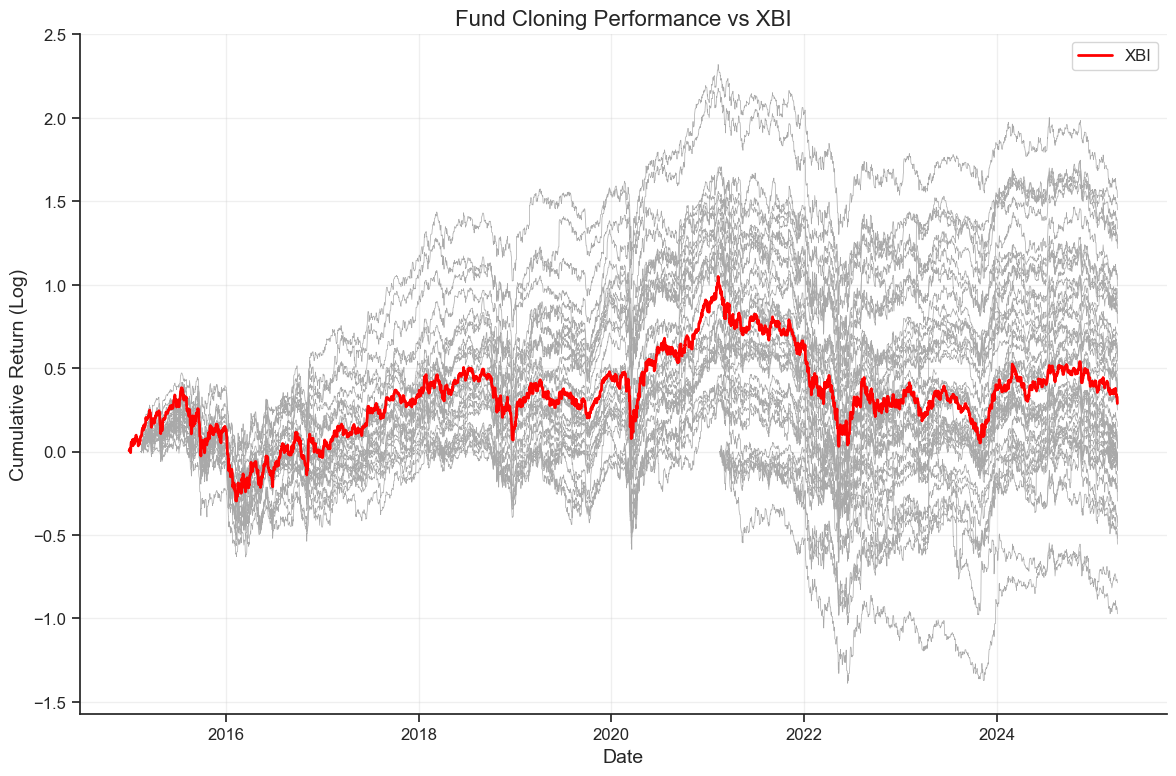

In [171]:
xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-03-31')]
xbi_cum_perf = np.log(1+xbi).cumsum()

# Create a dictionary to store fund performance for later reference
fund_performances = {}
fund_idio_returns = {}

# Process each fund first
for fund in bt.manager_df[~(bt.manager_df['Public_Start'].isna() | bt.manager_df['Public_End'].isna() | bt.manager_df['Not_Biotech'] | bt.manager_df['Contamination'])]['Master'].unique():
    print(fund)

    holdings = bt.get_fund_holdings(fund, contamination = bt.manager_df.loc[bt.manager_df['Master'] == fund, 'Contamination'].values[0])
    holdings.index = holdings.index + pd.Timedelta(days=45)

    #if(fund in fund_portfolios):
    #    holdings = fund_portfolios[fund]
    #else:
    #    print(f"{fund} has no portfolio")
    #    continue
    holdings = bt.adjust_holdings(holdings, max_participation=0.1, port_size=10000000, pct=0.999)

    if(len(holdings) == 0):
        print(f"{fund} has no holdings")
        continue
    perf = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))
    attr = bt.get_factor_attribution(holdings, factor_scores, factor_rets, max(holdings.index)+pd.Timedelta(days=90))

    # Store just the performance in the dictionary
    fund_performances[fund] = perf
    fund_idio_returns[fund] = attr['Idio']


# Create first figure for total performance
plt.figure(figsize=(12, 8))  # Increase figure size

# Plot each fund in light grey with no labels
for fund in fund_performances:
    perf = fund_performances[fund].fillna(0)
    cum_perf = np.log(1+perf).cumsum()
    plt.plot(cum_perf, color='darkgrey', linewidth=0.5)

# Add XBI in red with a label
plt.plot(xbi_cum_perf, color='red', linewidth=2, label='XBI')
plt.legend(fontsize=12)  # Larger legend text
plt.grid(True, alpha=0.3)
plt.title('Fund Cloning Performance vs XBI', fontsize=16)  # Larger title
plt.ylabel('Cumulative Return (Log)', fontsize=14)  # Larger y-axis label
plt.xlabel('Date', fontsize=14)  # Add and size x-axis label
plt.xticks(fontsize=12)  # Larger x-axis tick labels
plt.yticks(fontsize=12)  # Larger y-axis tick labels
plt.tight_layout()  # Adjust layout to fit larger elements
plt.show()

In [181]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

HALF_LIFE = 365*2

xbi = bt.sec_rets_df['XBI US'].loc[pd.Timestamp('2014-12-31'):pd.Timestamp('2025-03-31')]

quarter_ends = pd.date_range(
    start=pd.Timestamp('2014-12-31'),
    end=pd.Timestamp('2024-12-31'),
    freq='QE'  # Quarter end frequency (updated from 'Q')
)
quarter_ends_delayed = [date + pd.Timedelta(days=45) for date in quarter_ends]

# Create a DataFrame to store all IR values
all_ir_data = []

for date in quarter_ends_delayed:
    for fund in fund_performances:
        if date - pd.Timedelta(days=365) not in fund_performances[fund].index or (date >= max(fund_performances[fund].index)):
            continue

        cur_fund_perf = fund_performances[fund].loc[:date]
        xbi_perf = xbi.loc[cur_fund_perf.index]
        # Join XBI performance to fund performance
        combined_perf = pd.DataFrame({
            'fund': cur_fund_perf,
            'xbi': xbi_perf
        })
        # Drop rows where either fund or XBI performance is exactly 0
        combined_perf = combined_perf[(combined_perf['fund'] != 0) & (combined_perf['xbi'] != 0)]
        # Calculate exponential weights with a half-life of 255 days
        days_diff = (date - combined_perf.index).days
        combined_perf['Weight'] = np.exp(-np.log(2) * days_diff / HALF_LIFE)

        try:
            model = sm.WLS(combined_perf['fund'], sm.add_constant(combined_perf['xbi']), weights=combined_perf['Weight'])
            results = model.fit()
        except:
            print(f"Error fitting model for {fund} on {date}")
            continue

        daily_vol = np.sqrt(np.sum(combined_perf['Weight'] * results.resid**2)/np.sum(combined_perf['Weight']))
        daily_alpha = np.sum(results.resid * combined_perf['Weight'])/np.sum(combined_perf['Weight']) + results.params.iloc[0]

        idio_perf = fund_idio_returns[fund].loc[cur_fund_perf.index]
        weighted_idio_alpha = np.sum(idio_perf * combined_perf['Weight'])/np.sum(combined_perf['Weight'])
        weighted_idio_vol = np.sqrt(np.sum((idio_perf-weighted_idio_alpha)**2 * combined_perf['Weight'])/np.sum(combined_perf['Weight']))
        
        # Add to our list of IR data
        all_ir_data.append({
            'date': date,
            'fund': fund,
            'ir': daily_alpha/daily_vol,
            'alpha': daily_alpha,
            'idio_alpha': weighted_idio_alpha,
            'idio_vol': weighted_idio_vol,
            'idio_ir': weighted_idio_alpha/weighted_idio_vol
        })

# Convert the list to a DataFrame
ir_df = pd.DataFrame(all_ir_data)

In [209]:
# Filter out negative IR values
#ir_df.loc[ir_df['ir'] < 0, 'ir'] = 0

# For each date, get top 10 funds by IR and set their weights to 0.1, others to 0
for date in ir_df['date'].unique():
    date_mask = ir_df['date'] == date
    top_10_mask = ir_df[date_mask].nlargest(10, 'alpha').index
    ir_df.loc[date_mask, 'weight'] = 0
    ir_df.loc[top_10_mask, 'weight'] = 0.1

# Create a blank DataFrame with all securities from sec_rets_df and all dates from ir_df
all_dates = ir_df['date'].unique()
all_securities = bt.sec_rets_df.columns.tolist()
final_holdings = pd.DataFrame(0.0, index=all_dates, columns=all_securities)
fund_holdings = {}

for fund in ir_df['fund'].unique():
    fund_holdings[fund] = bt.get_fund_holdings(fund)
    #fund_holdings[fund] = fund_portfolios[fund]
    fund_holdings[fund].index = fund_holdings[fund].index + pd.Timedelta(days=45)

for date in all_dates:
    # Get the funds and their weights for that date
    funds_on_date = ir_df[ir_df['date'] == date]
    for fund, weight in zip(funds_on_date['fund'], funds_on_date['weight']):
        # Only add values for columns that exist in both DataFrames
        columns = fund_holdings[fund].columns
        final_holdings.loc[date, columns] += fund_holdings[fund].loc[date, columns] * weight

# Set negative holdings to 0
final_holdings[final_holdings < 0] = 0

# Renormalize by dividing each row by its sum
row_sums = final_holdings.sum(axis=1)
final_holdings = final_holdings.div(row_sums, axis=0)

final_holdings = bt.adjust_holdings(final_holdings, max_participation=0.1, port_size=100000000, n=100)


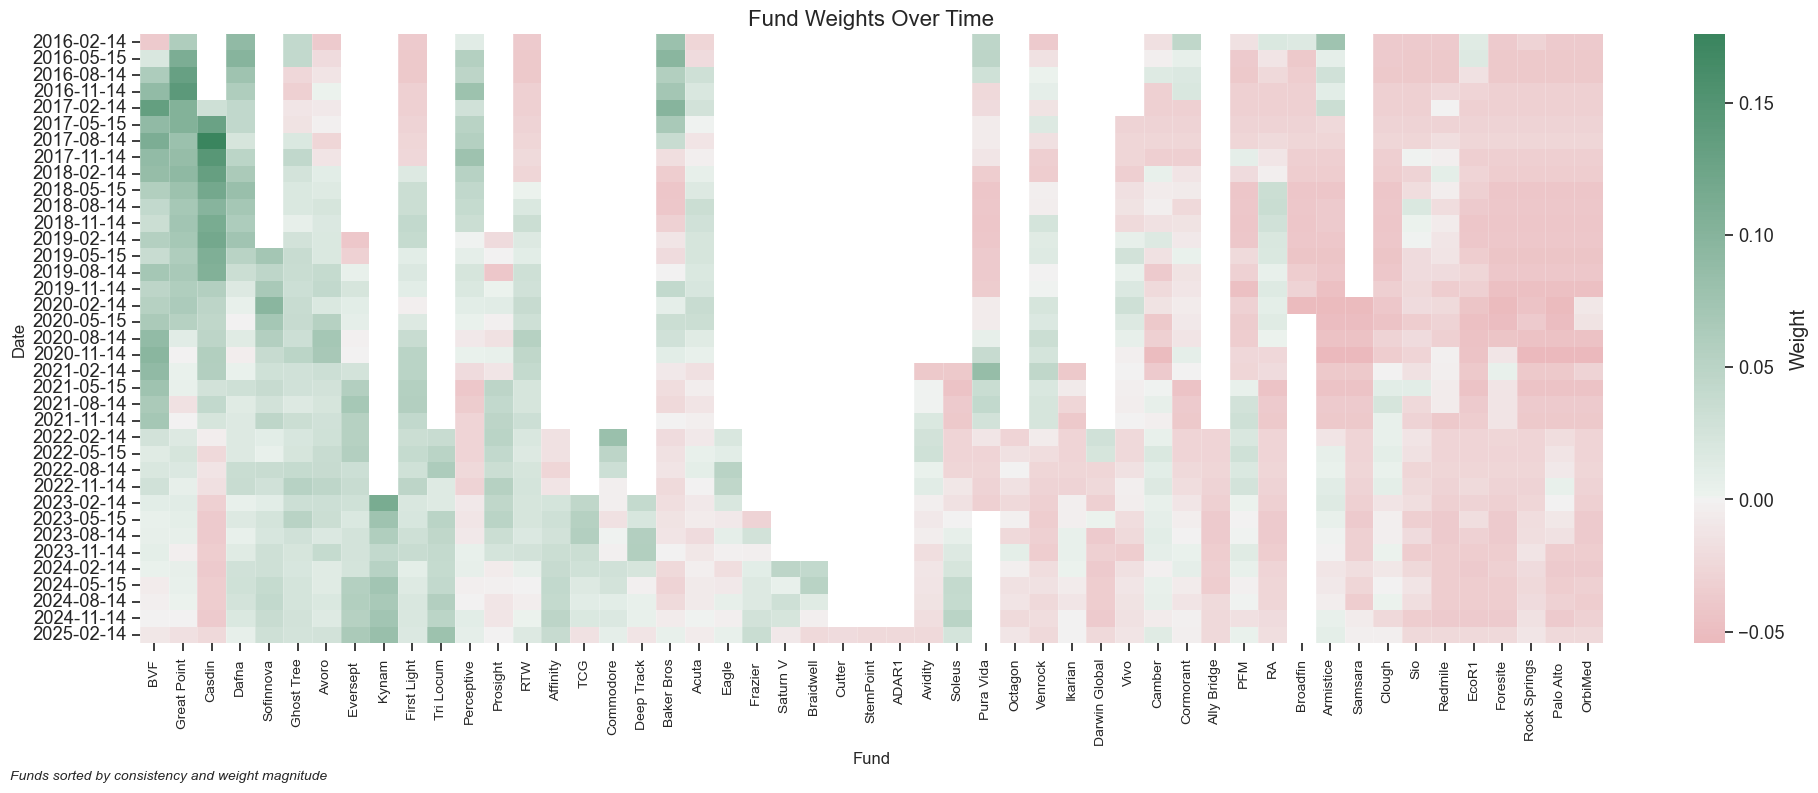

In [210]:
weight_pivot = ir_df.pivot(index='date', columns='fund', values='weight')
# Replace zeros with NaN for better visualization
weight_pivot = weight_pivot.replace(0, np.nan)

# Calculate the sum of weights over all time for each fund
fund_weight_sums = weight_pivot.sum()

# Sort funds by their total weight sum over all time
sorted_funds = fund_weight_sums.sort_values(ascending=False).index
weight_pivot = weight_pivot[sorted_funds]

# Create a diverging colormap centered at 0 with green for positive and red for negative
custom_cmap = sns.diverging_palette(10, 145, as_cmap=True)  # Changed order to make green positive

# Plot - Regular weights with increased width to show all funds
plt.figure(figsize=(20, 8))  # Increased width from 12 to 20
ax1 = sns.heatmap(weight_pivot, cmap=custom_cmap, center=0, cbar_kws={'label': 'Weight'})

plt.title('Fund Weights Over Time', fontsize=16)
plt.xlabel('Fund', fontsize=12)
plt.ylabel('Date', fontsize=12)

# Rotate x-axis labels for better readability and ensure all are visible
plt.xticks(rotation=90, fontsize=10)
plt.tick_params(axis='x', which='major', pad=5)  # Add padding for x-axis labels

# Format dates on y-axis
date_format = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
ax1.yaxis.set_major_formatter(date_format)

# Fix the yticks issue by getting the correct number of ticks
y_locs = np.arange(len(weight_pivot.index)) + 0.5  # Center of each cell
y_labels = [d.strftime('%Y-%m-%d') for d in weight_pivot.index]
plt.yticks(y_locs, y_labels)

# Add grid lines to make it easier to track across the chart
ax1.grid(False)  # Turn off the default grid
for i in range(len(sorted_funds)):
    plt.axvline(x=i, color='white', linewidth=0.5, alpha=0.3)

# Add a descriptive annotation
plt.figtext(0.01, 0.01, "Funds sorted by consistency and weight magnitude", 
            fontsize=10, style='italic')

# Ensure all labels are visible
plt.tight_layout()
plt.show()


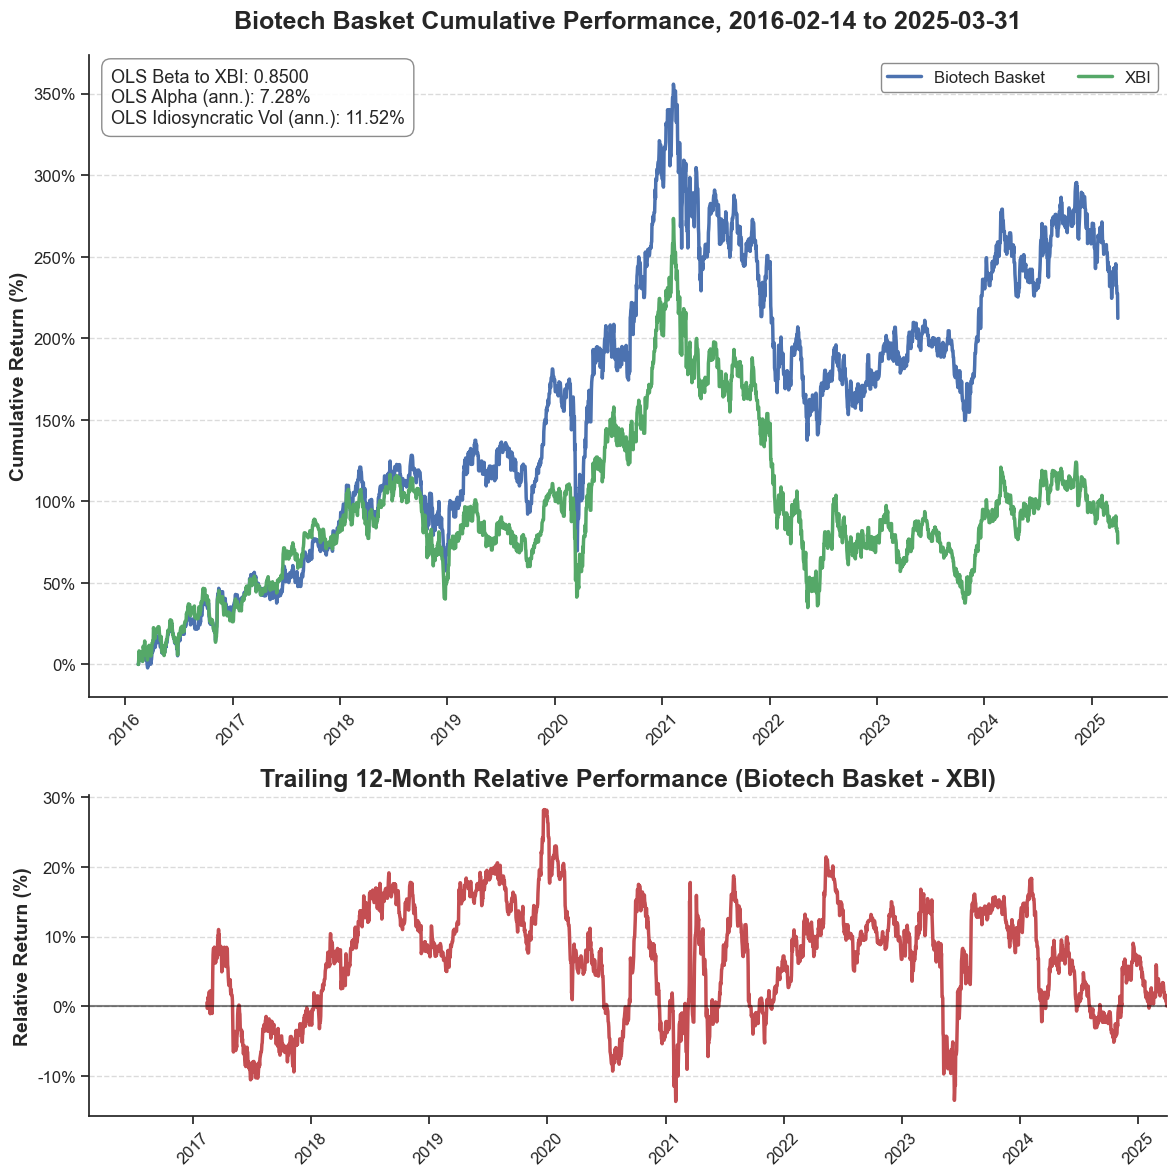

In [211]:
# Get strategy returns and XBI returns
strategy_returns = bt.get_strategy_returns(final_holdings, pd.Timestamp('2025-03-31'))
xbi_returns = bt.sec_rets_df['XBI US'].loc[strategy_returns.index[0]:strategy_returns.index[-1]]

# Convert to cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod() - 1
xbi_cumulative = (1 + xbi_returns).cumprod() - 1

# Create a DataFrame for plotting
cumulative_returns = pd.DataFrame({
    'Biotech Basket': strategy_cumulative,
    'XBI': xbi_cumulative
})

# Calculate trailing 12-month cumulative returns for both strategy and XBI
strategy_t12m = (1 + strategy_returns).rolling(window=365).apply(lambda x: x.prod()) - 1
xbi_t12m = (1 + xbi_returns).rolling(window=365).apply(lambda x: x.prod()) - 1

# Calculate trailing 12-month relative performance (Strategy T12M - XBI T12M)
trailing_12m_relative = strategy_t12m - xbi_t12m
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Compute beta and alpha to XBI for regular strategy
returns_for_regression = pd.DataFrame({
    'strategy': strategy_returns,
    'xbi': xbi_returns
})
returns_for_regression = returns_for_regression.dropna()
returns_for_regression = returns_for_regression[(returns_for_regression['strategy'] != 0) | 
                                               (returns_for_regression['xbi'] != 0)]

# Add a constant to the regression model
X = sm.add_constant(returns_for_regression['xbi'])
Y = returns_for_regression['strategy']

# Fit the regression model
model = sm.OLS(Y, X).fit()
# Extract beta and alpha
beta = model.params['xbi']
alpha = model.params['const']
alpha_annualized = alpha * len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25)

idio_vol = model.resid.std()
idio_vol_annualized = idio_vol * np.sqrt(len(returns_for_regression) / ((strategy_returns.index[-1] - strategy_returns.index[0]).days / 365.25))
# Set a professional theme and color palette
sns.set_theme(style="ticks", palette="colorblind", font="Arial", font_scale=1.2)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Plot 1: Cumulative Performance
colors = ["#4C72B0", "#55A868"]  # Different professional colors
ax1.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=cumulative_returns, ax=ax1, linewidth=2.5, palette=colors, dashes=False)

# Format the plot
ax1.set_title(f"Biotech Basket Cumulative Performance, {cumulative_returns.index.min().strftime('%Y-%m-%d')} to {cumulative_returns.index.max().strftime('%Y-%m-%d')}", fontsize=18, fontweight='bold', pad=20)
ax1.set_ylabel("Cumulative Return (%)", fontsize=14, fontweight='bold')
ax1.set_xlabel("")  # Remove x-axis label
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Enhance legend
legend = ax1.legend(title="", loc='upper right', ncol=2, frameon=True, framealpha=0.9, 
                   fontsize=12, edgecolor='gray')
legend.get_frame().set_linewidth(1)

# Add metrics box with enhanced styling
metrics_text = (
    f"OLS Beta to XBI: {beta:.4f}\n"
    f"OLS Alpha (ann.): {alpha_annualized*100:.2f}%\n"
    f"OLS Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%"
)

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                          facecolor='white', 
                                          edgecolor='gray', 
                                          alpha=0.9,
                                          linewidth=1))

# Plot 2: Trailing 12-month Relative Performance
ax2.grid(True, linestyle='--', alpha=0.7, axis='y')
sns.lineplot(data=trailing_12m_relative, color="#C44E52", 
            ax=ax2, linewidth=2.5)

# Format the second plot
ax2.set_title("Trailing 12-Month Relative Performance (Biotech Basket - XBI)", 
             fontsize=18, fontweight='bold')
ax2.set_ylabel("Relative Return (%)", fontsize=14, fontweight='bold')
ax2.set_xlabel("")  # Remove x-axis label
ax2.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1.5)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

# Ensure both plots have the same x-axis range
ax2.set_xlim(cumulative_returns.index.min(), cumulative_returns.index.max())

plt.tight_layout()
plt.show()


In [212]:
# Get the holdings for the specified date
holdings = final_holdings.loc[pd.Timestamp('2025-02-14')].dropna().loc[lambda x: x != 0]
# Sort by size (value) in descending order
sorted_holdings = holdings.sort_values(ascending=False)
# Convert to percentage and print the sorted holdings
percentage_holdings = sorted_holdings * 100
print(percentage_holdings)

# Calculate and print average, max, and min weights across all dates
hhi = (1/(final_holdings**2).sum(axis=1))
max_weight = final_holdings.max().max() * 100
print(f"Avg Effective Concentration: {hhi.mean():.2f}")
print(f"Minimum Effective Concentration: {hhi.min():.2f}")
print(f"Average max weight: {final_holdings.max(axis=1).mean()*100:.2f}%")
print(f"Maximum weight across all dates: {max_weight:.2f}%")


NTRA US     20.425159
GSK LN       5.797025
PCVX US      5.272741
MDGL US      3.875981
ARGX BB      3.536143
AXSM US      2.935659
VRNA US      2.452006
NOVOB DC     2.092957
CLDX US      2.041885
SNDX US      2.020070
RVTY US      1.864431
BCRX US      1.751324
TEVA IT      1.702376
UTHR US      1.691166
ALKS US      1.655748
BMY US       1.571120
VERA US      1.476963
ARQT US      1.367582
MRUS US      1.306594
TGTX US      1.298571
NAMS US      1.257172
TVTX US      1.184789
DVAX US      1.168064
PTCT US      1.154335
VTRS US      1.019075
AVDL US      1.008339
ACLX US      1.006960
MIRM US      0.921376
TECH US      0.917526
LQDA US      0.899715
WVE US       0.897227
KRYS US      0.889025
JAZZ US      0.850380
TWST US      0.842205
AZN LN       0.766251
EOLS US      0.765536
NUVL US      0.748327
GILD US      0.700980
TARS US      0.659256
GRF SM       0.653376
STVN US      0.638972
COGT US      0.595304
IMCR US      0.581854
PTGX US      0.573953
PFE US       0.572312
ZEAL DC   

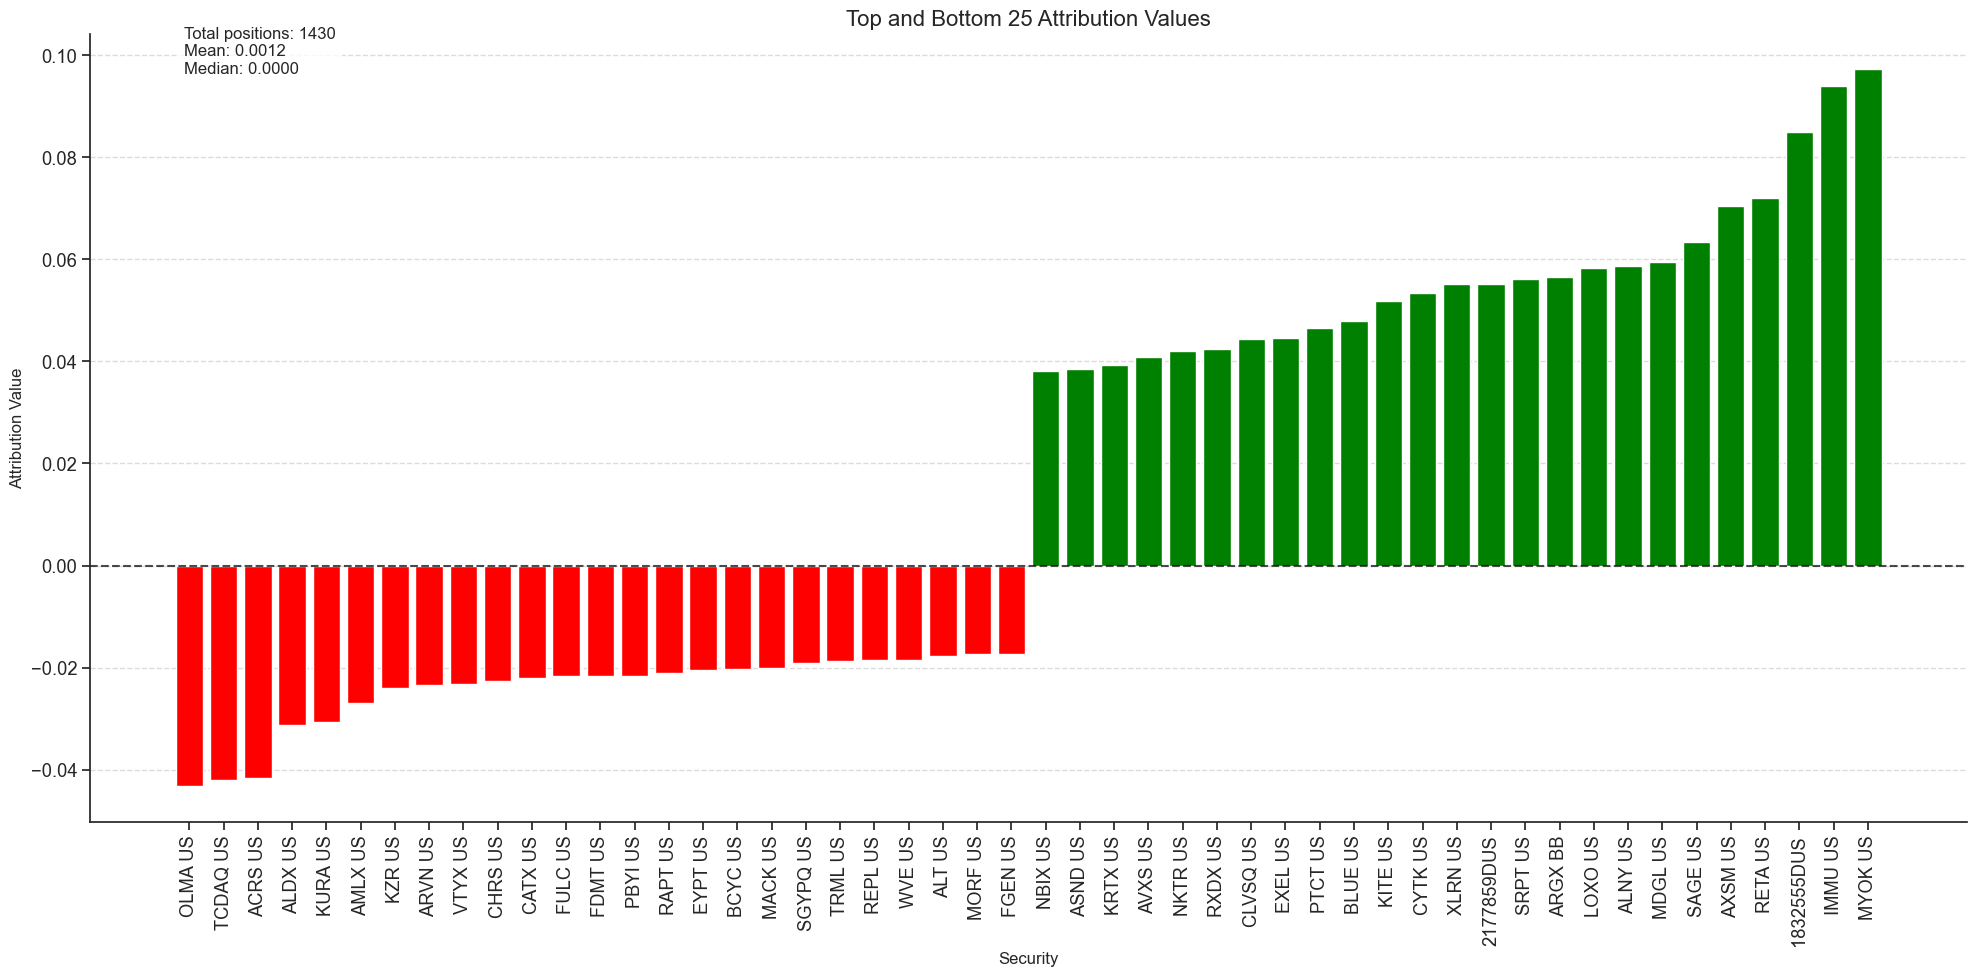

In [161]:
attr = bt.get_strategy_attribution(final_holdings, end_date=pd.Timestamp('2025-03-31'))
attr = FilingBacktester.carino_attribution(attr)

# Sort all attribution values from smallest to largest
plot_data = attr.sort_values()

# Get the bottom 25 and top 25 attributions
bottom_25 = plot_data.head(25)
top_25 = plot_data.tail(25)

# Combine them into a single dataframe for plotting
combined_data = pd.concat([bottom_25, top_25])

# Create a bar plot for the top and bottom 25 attributions with wider figure
plt.figure(figsize=(20, 10))
bars = plt.bar(combined_data.index, combined_data.values, color=['red' if x < 0 else 'green' for x in combined_data.values])

# Add labels and title
plt.title('Top and Bottom 25 Attribution Values', fontsize=16)
plt.xlabel('Security', fontsize=12)
plt.ylabel('Attribution Value', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add summary statistics as text
plt.text(0.05, 0.95, f"Total positions: {len(attr)}\nMean: {plot_data.mean():.4f}\nMedian: {plot_data.median():.4f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [163]:
factor_ctr = bt.get_factor_attribution(final_holdings, factor_scores, factor_rets, pd.Timestamp('2025-03-31'))
carino_factor_ctr = FilingBacktester.carino_attribution(factor_ctr)
print(carino_factor_ctr)
print(carino_factor_ctr.sum())
print(carino_factor_ctr/carino_factor_ctr.sum())

Size       -0.908664
Momentum    0.259530
Reversal    0.103352
Market      1.012068
Idio        1.222819
dtype: float64
1.6891045918412928
Size       -0.537956
Momentum    0.153649
Reversal    0.061188
Market      0.599174
Idio        0.723945
dtype: float64


C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_17616\445671474.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_17616\445671474.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


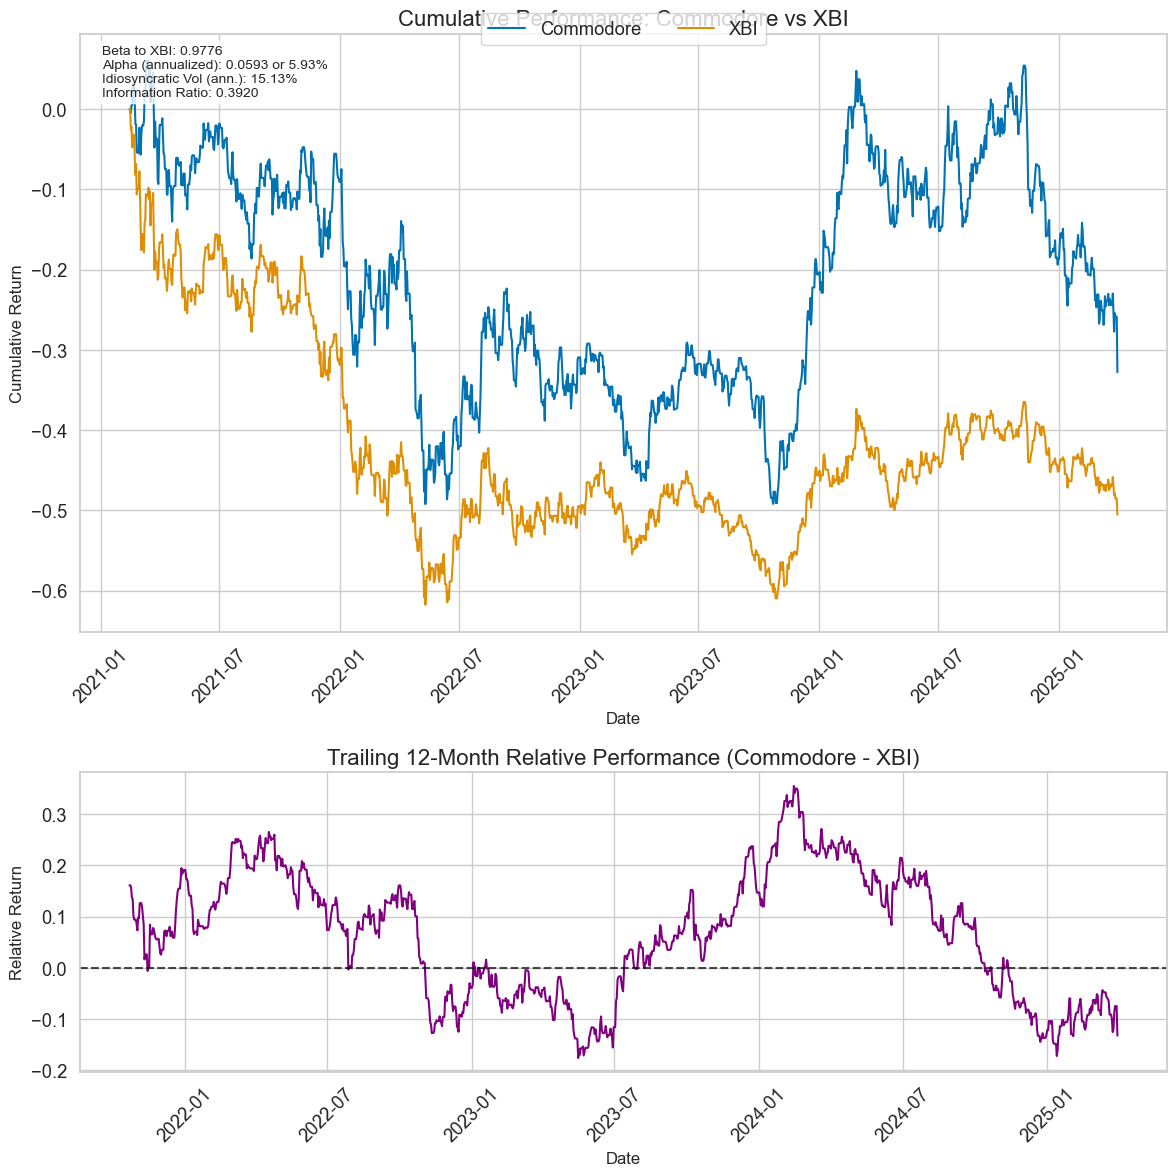

In [194]:
# Set the Master fund to analyze
master_fund = "Commodore"  # Change this to the fund you want to analyze

# Get the fund's holdings
holdings = bt.get_fund_holdings(master_fund, contamination=False)
holdings = bt.adjust_holdings(holdings, max_participation=0.1, port_size=10000000)
# Add 45 days to the holdings index to account for filing delay
holdings.index = holdings.index + pd.Timedelta(days=45)
perf = bt.get_strategy_returns(holdings, max(holdings.index)+pd.Timedelta(days=90))

# Get XBI returns for comparison
xbi = bt.sec_rets_df['XBI US'].loc[perf.index[0]:perf.index[-1]]
xbi_cum_perf = (1+xbi).cumprod()-1

# Replace NaN values with 0 to avoid issues in cumulative performance calculation
perf = perf.fillna(0)
cum_perf = (1+perf).cumprod()-1

# Calculate trailing 12-month relative performance
trailing_12m = pd.DataFrame({
    master_fund: perf.rolling(252).sum(),
    'XBI': xbi.rolling(252).sum()
})
trailing_12m_relative = trailing_12m[master_fund] - trailing_12m['XBI']

# Calculate regression metrics
X = sm.add_constant(xbi)
model = sm.OLS(perf, X).fit()
beta = model.params[1]
alpha = model.params[0]
alpha_annualized = alpha * 252
idio_vol = np.std(model.resid)
idio_vol_annualized = idio_vol * np.sqrt(252)
information_ratio = alpha_annualized / idio_vol_annualized

# Create a DataFrame for cumulative returns
cumulative_returns = pd.DataFrame({
    master_fund: cum_perf,
    'XBI': xbi_cum_perf
})

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Cumulative Performance
sns.set_style("whitegrid")
sns.lineplot(data=cumulative_returns, dashes=False, ax=ax1)
ax1.set_title(f"Cumulative Performance: {master_fund} vs XBI", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Cumulative Return", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Add text box with metrics to the top left corner of the main plot
metrics_text = (f"Beta to XBI: {beta:.4f}\n"
                f"Alpha (annualized): {alpha_annualized:.4f} or {alpha_annualized*100:.2f}%\n"
                f"Idiosyncratic Vol (ann.): {idio_vol_annualized*100:.2f}%\n"
                f"Information Ratio: {information_ratio:.4f}")

ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Trailing 12-month Relative Performance
sns.lineplot(data=trailing_12m_relative, color='purple', ax=ax2)
ax2.set_title(f"Trailing 12-Month Relative Performance ({master_fund} - XBI)", fontsize=16)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Relative Return", fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

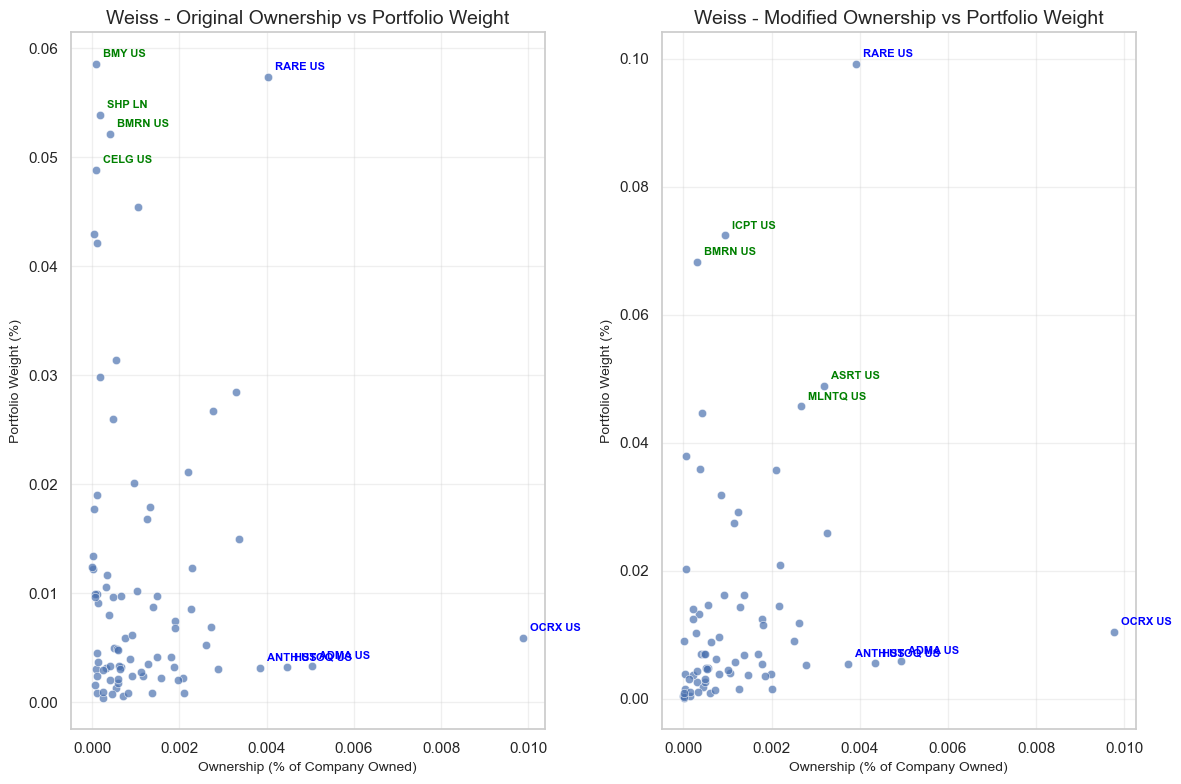

In [537]:
Master = "Weiss"

holdings_mv = bt.get_fund_holdings(Master, mvs=True)
holdings_pct = bt.get_fund_holdings(Master, mvs=False)
holdings_modified_mv = bt.get_fund_holdings(Master, mvs=True, contamination=True)
holdings_modified_pct = bt.get_fund_holdings(Master, mvs=False, contamination=True)

mkt_cap = bt.sec_mkt_cap_df.reindex(index=holdings_mv.index, columns=holdings_mv.columns)
ownership = holdings_mv.div(mkt_cap)
ownership_modified = holdings_modified_mv.div(mkt_cap)

mean_ownership = ownership.sum(axis=1)/mkt_cap.sum(axis=1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Get the latest data for both original ownership and percentage holdings
latest_ownership = ownership.iloc[-1].reset_index()
latest_ownership.columns = ['Ticker', 'Ownership']

latest_pct = holdings_pct.iloc[-1].reset_index()
latest_pct.columns = ['Ticker', 'Percentage']

# Merge the two dataframes for original data
scatter_data_original = pd.merge(latest_ownership, latest_pct, on='Ticker')
scatter_data_original = scatter_data_original.dropna()
scatter_data_original = scatter_data_original[(scatter_data_original['Ownership'] > 0) & (scatter_data_original['Percentage'] > 0)]

# Get the latest data for modified ownership and percentage holdings
latest_modified_ownership = ownership_modified.iloc[-1].reset_index()
latest_modified_ownership.columns = ['Ticker', 'Modified_Ownership']

latest_modified_pct = holdings_modified_pct.iloc[-1].reset_index()
latest_modified_pct.columns = ['Ticker', 'Modified_Percentage']

# Merge the two dataframes for modified data
scatter_data_modified = pd.merge(latest_modified_ownership, latest_modified_pct, on='Ticker')
scatter_data_modified = scatter_data_modified.dropna()
scatter_data_modified = scatter_data_modified[(scatter_data_modified['Modified_Ownership'] > 0) & (scatter_data_modified['Modified_Percentage'] > 0)]

# Get top 5 highest ownership and percentage names for both datasets
top_5_ownership_original = scatter_data_original.sort_values('Ownership', ascending=False).head(5)
top_5_pct_original = scatter_data_original.sort_values('Percentage', ascending=False).head(5)

top_5_ownership_modified = scatter_data_modified.sort_values('Modified_Ownership', ascending=False).head(5)
top_5_pct_modified = scatter_data_modified.sort_values('Modified_Percentage', ascending=False).head(5)

# Plot 1: Original Data
sns.scatterplot(data=scatter_data_original, x='Ownership', y='Percentage', alpha=0.7, ax=ax1)

# Label top points in original plot
for _, row in top_5_ownership_original.iterrows():
    ax1.annotate(row['Ticker'], 
                xy=(row['Ownership'], row['Percentage']),
                xytext=(5, 5),
                textcoords='offset points',
                color='blue',
                fontweight='bold',
                fontsize=8)

for _, row in top_5_pct_original.iterrows():
    if row['Ticker'] not in top_5_ownership_original['Ticker'].values:
        ax1.annotate(row['Ticker'], 
                    xy=(row['Ownership'], row['Percentage']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color='green',
                    fontweight='bold',
                    fontsize=8)

ax1.set_title(f"{Master} - Original Ownership vs Portfolio Weight", fontsize=14)
ax1.set_xlabel("Ownership (% of Company Owned)", fontsize=10)
ax1.set_ylabel("Portfolio Weight (%)", fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Modified Data
sns.scatterplot(data=scatter_data_modified, x='Modified_Ownership', y='Modified_Percentage', alpha=0.7, ax=ax2)

# Label top points in modified plot
for _, row in top_5_ownership_modified.iterrows():
    ax2.annotate(row['Ticker'], 
                xy=(row['Modified_Ownership'], row['Modified_Percentage']),
                xytext=(5, 5),
                textcoords='offset points',
                color='blue',
                fontweight='bold',
                fontsize=8)

for _, row in top_5_pct_modified.iterrows():
    if row['Ticker'] not in top_5_ownership_modified['Ticker'].values:
        ax2.annotate(row['Ticker'], 
                    xy=(row['Modified_Ownership'], row['Modified_Percentage']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color='green',
                    fontweight='bold',
                    fontsize=8)

ax2.set_title(f"{Master} - Modified Ownership vs Portfolio Weight", fontsize=14)
ax2.set_xlabel("Ownership (% of Company Owned)", fontsize=10)
ax2.set_ylabel("Portfolio Weight (%)", fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


First date in holdings: 2014-12-31 00:00:00


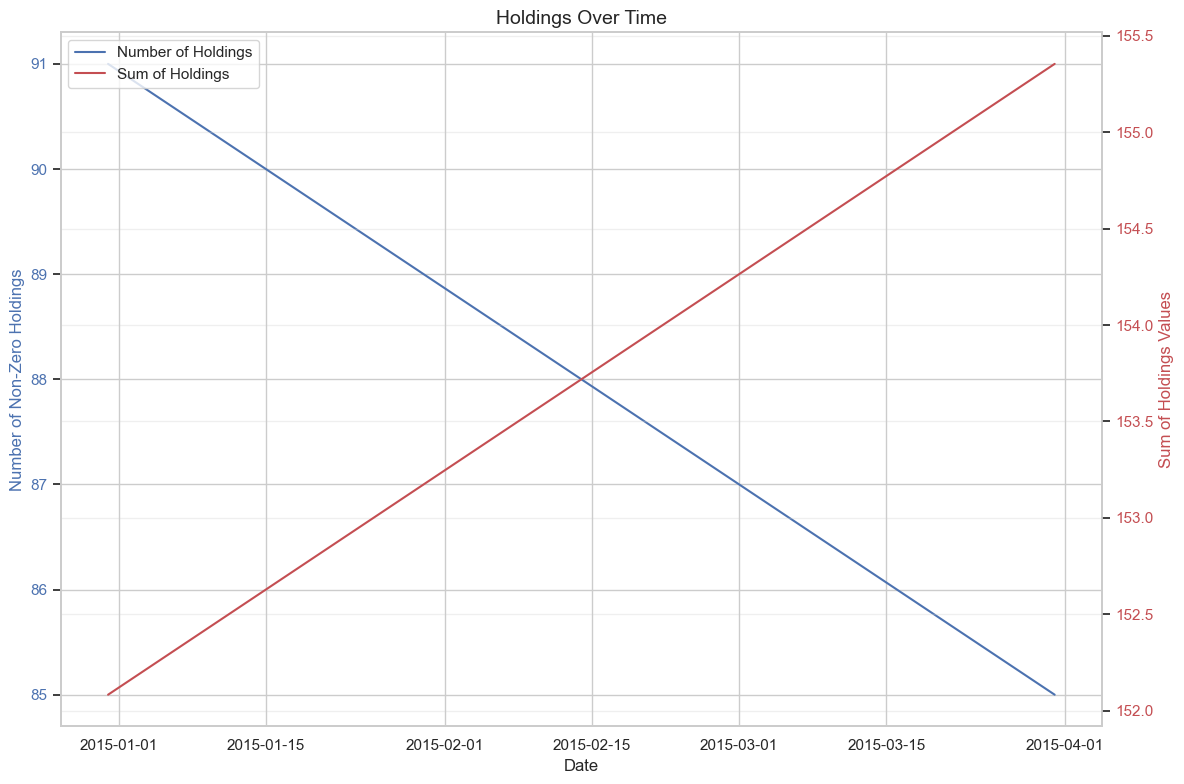

In [ ]:
# Get the fund holdings
holdings = bt.get_fund_holdings(Master, mvs=True)

# Count non-zero columns per row
nonzero_counts = holdings.astype(bool).sum(axis=1)

# Calculate sum of holdings values
holdings_sum = holdings.sum(axis=1)

# Display the first date in the holdings
first_date = holdings.index[0]
print(f"First date in holdings: {first_date}")

# Plot the counts and sum
fig, ax1 = plt.subplots(figsize=(1200/100, 800/100))

# Plot number of holdings
ax1.plot(nonzero_counts.index, nonzero_counts.values, 'b-', label='Number of Holdings')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Number of Non-Zero Holdings", fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create second y-axis for sum
ax2 = ax1.twinx()
ax2.plot(holdings_sum.index, holdings_sum.values, 'r-', label='Sum of Holdings')
ax2.set_ylabel("Sum of Holdings Values", fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Holdings Over Time", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [634]:
dates = pd.date_range(start='2014-12-31', end='2024-12-31', freq='QE') + pd.DateOffset(days=45)
raw_rets = bt.get_period_returns(dates)
idio_rets = bt.get_period_idio_returns(factor_scores, factor_rets)
raw_rets = raw_rets.shift(-1) # Lag raw returns by 1 period to account for holding period of 1 full quarter from day of report
idio_rets = idio_rets.shift(-1) # Lag idiosyncratic returns by 1 period to account for holding period of 1 full quarter from day of report

eligible_data = bt.eligible_securities_df.reindex(index=raw_rets.index, columns=raw_rets.columns)
eligible_data = eligible_data.replace(False, np.nan)

raw_rets = raw_rets.multiply(eligible_data)
idio_rets = idio_rets.multiply(eligible_data)

C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_19492\4165470532.py:428: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarter_end_returns = sec_rets_df.groupby('quarter_end').apply(
C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_19492\4165470532.py:464: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarter_end_returns = idio_returns.groupby('quarter_end').apply(
C:\Users\NWeatherly\AppData\Local\Temp\ip

In [652]:
holdings_data = []

for fund in bt.manager_df['Master'].unique():
    # Get holdings for the fund
    holdings = bt.get_fund_holdings(fund, contamination = bt.manager_df.loc[bt.manager_df['Master'] == fund, 'Contamination'].values[0])
    holdings = bt.adjust_holdings(holdings, pct=0.999)
    #holdings = holdings > 0
    holdings = holdings.fillna(0)
    holdings.index = holdings.index + pd.DateOffset(days=45)  # Add 45 days to account for filing delay
    
    # Unravel holdings to have date and ticker as index
    holdings_unraveled = holdings.stack().reset_index()
    holdings_unraveled.columns = ['date', 'ticker', 'is_held']
    
    # Filter to only where holdings are True
    holdings_true = holdings_unraveled[holdings_unraveled['is_held'] == True].copy()
    
    # Check if the DataFrame is empty before trying to set values
    if not holdings_true.empty:
        # Add fund column using .loc to avoid SettingWithCopyWarning
        holdings_true.loc[:, 'fund'] = fund
        
        # Append to the list
        holdings_data.append(holdings_true)


all_holdings = pd.concat(holdings_data, ignore_index=True)
    
# Final dataset with date, ticker, fund, and is_held columns
holdings_dataset = all_holdings[['date', 'ticker', 'fund', 'is_held']]
    
# Pivot the data to have date and ticker as index, and funds as columns
holdings_dataset = holdings_dataset.pivot_table(
    index=['date', 'ticker'], 
    columns='fund', 
    values='is_held', 
    fill_value=False).reset_index()



In [653]:
# First, display the holdings_dataset structure

idio_rets_aligned = idio_rets.copy()
idio_rets_aligned = idio_rets_aligned.reset_index()
idio_rets_aligned = idio_rets_aligned.rename(columns={'quarter_end': 'date'})
idio_rets_aligned = idio_rets_aligned.melt(id_vars=['date'], var_name='ticker', value_name='idio_return')
idio_rets_aligned = idio_rets_aligned.set_index(['date', 'ticker'])
idio_rets_aligned = idio_rets_aligned.reset_index()
idio_rets_aligned = idio_rets_aligned.dropna(subset=['idio_return'])

# Perform the left join - keeping all rows from idio_rets_aligned
merged_data = pd.merge(
    idio_rets_aligned,
    holdings_dataset,
    on=['date', 'ticker'],
    how='left'
)

# Fill any NaN values in the fund columns with False (where holdings weren't found)
fund_columns = [col for col in merged_data.columns if col not in ['date', 'ticker', 'idio_return']]
merged_data[fund_columns] = merged_data[fund_columns].fillna(False)

# Set the index back to date and ticker
merged_data = merged_data.set_index(['date', 'ticker'])


fund,date,ticker,Atlas,Blue Water,Consonance,Darwin Global,Duquesne
0,2015-08-14,ILMN US,False,False,False,False,1.0
1,2015-11-14,ILMN US,False,False,False,False,1.0
2,2016-02-14,SANN SW,False,False,1.0,False,False
3,2016-05-15,SANN SW,False,False,1.0,False,False
4,2016-05-15,ZTS US,False,False,False,False,1.0


In [656]:
# Perform random forest regression of idio_return on fund holdings with heavy regularization

# Reset index to make date and ticker regular columns
regression_data = merged_data.reset_index()

# Get list of fund columns (all boolean columns except date, ticker, and idio_return)
fund_columns = [col for col in regression_data.columns if col not in ['date', 'ticker', 'idio_return']]

# Convert boolean values to integers (0/1) for regression
for col in fund_columns:
    regression_data[col] = regression_data[col].astype(int)

# Check for any object dtypes and convert to numeric
regression_data['idio_return'] = pd.to_numeric(regression_data['idio_return'], errors='coerce')
regression_data = regression_data.dropna(subset=['idio_return'])

# Clip idiosyncratic returns to +/- 3 standard deviations to handle outliers
mean_idio = regression_data['idio_return'].mean()
std_idio = regression_data['idio_return'].std()
regression_data['idio_return'] = regression_data['idio_return'].clip(
    lower=mean_idio - 3*std_idio, 
    upper=mean_idio + 3*std_idio
)

# Import necessary libraries for random forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for random forest regression
X = regression_data[fund_columns]
y = regression_data['idio_return']

# Verify data types before regression
print("X dtypes:", X.dtypes.unique())
print("y dtype:", y.dtype)

# Split data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a heavily regularized random forest model
# Using parameters that favor regularization: high min_samples_leaf, max_depth limit, high min_samples_split
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=10,
    min_samples_split=10,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_leaf': [10, 15],
    'min_samples_split': [10, 15]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate performance metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nTraining MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Out-of-bag R²: {best_model.oob_score_:.4f}")

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': fund_columns,
    'Importance': best_model.feature_importances_
})

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('Importance', ascending=False).head(10))

# Calculate overall R-squared on the full dataset
y_pred_full = best_model.predict(X)
r_squared = r2_score(y, y_pred_full)
print(f"\nOverall R-squared: {r_squared:.4f}")



X dtypes: [dtype('int32')]
y dtype: float64

Best Parameters:
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}

Training MSE: 0.131736
Test MSE: 0.134267
Training R²: -0.0000
Test R²: -0.0001
Out-of-bag R²: -0.0001

Top 10 Most Important Features:
         Feature  Importance
0          Atlas         0.0
1     Blue Water         0.0
2     Consonance         0.0
3  Darwin Global         0.0
4       Duquesne         0.0

Overall R-squared: -0.0000


In [472]:
Master = "EcoR1"

# Create quarter-end dates (with 45 day offset for reporting lag)
dates = pd.date_range(start='2014-12-31', end='2024-12-31', freq='QE') + pd.DateOffset(days=45)

# Get security returns dataframe and create a copy to avoid SettingWithCopyWarning
sec_rets_df = bt.sec_rets_df.copy()
ownership_df = bt.sec_mkt_cap_df.copy()

# Filter to relevant date range
sec_rets_df = sec_rets_df[(min(dates)+pd.Timedelta(days=1)):max(dates)].copy()

# Create a DataFrame with the quarter-end dates
quarter_ends_df = pd.DataFrame({'quarter_end': dates}, index=dates)
date_to_quarter = pd.Series(dates, index=dates)
quarter_end_series = date_to_quarter.reindex(sec_rets_df.index, method=None)

# Add the quarter end column to the security returns dataframe using .loc
sec_rets_df.loc[:, 'quarter_end'] = quarter_end_series
sec_rets_df.loc[:, 'quarter_end'] = sec_rets_df['quarter_end'].bfill()
# Calculate quarterly returns directly using prod
quarter_end_returns = sec_rets_df.groupby('quarter_end').apply(
    lambda x: (1 + x.drop('quarter_end', axis=1)).prod() - 1
)

quarter_end_returns = quarter_end_returns.sub(quarter_end_returns['XBI US'], axis=0)

holdings_df = bt.get_fund_holdings(Master, mvs=True)
holdings_df = bt.adjust_holdings(holdings_df, mvs=True, pct=0.999)
ownership_df = ownership_df.reindex(index=holdings_df.index, columns=holdings_df.columns)
ownership_df = holdings_df.div(ownership_df)
ownership_df = ownership_df.fillna(0)
holdings_df = holdings_df.div(holdings_df.sum(axis=1), axis=0)

holdings_df.index = holdings_df.index + pd.Timedelta(days=45)
ownership_df.index = ownership_df.index + pd.Timedelta(days=45)
quarter_end_returns = quarter_end_returns.reindex(index=holdings_df.index, columns=holdings_df.columns)

delta_ownership = ownership_df.diff()
delta_ownership = delta_ownership.fillna(0)

C:\Users\NWeatherly\AppData\Local\Temp\ipykernel_19492\1880137692.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarter_end_returns = sec_rets_df.groupby('quarter_end').apply(


Average MSE across folds: 0.1082 (±0.0084)
Print actual MSE: 0.1055
MSE of mean prediction: 0.1076
Average R² across folds: -0.0067 (±0.0033)


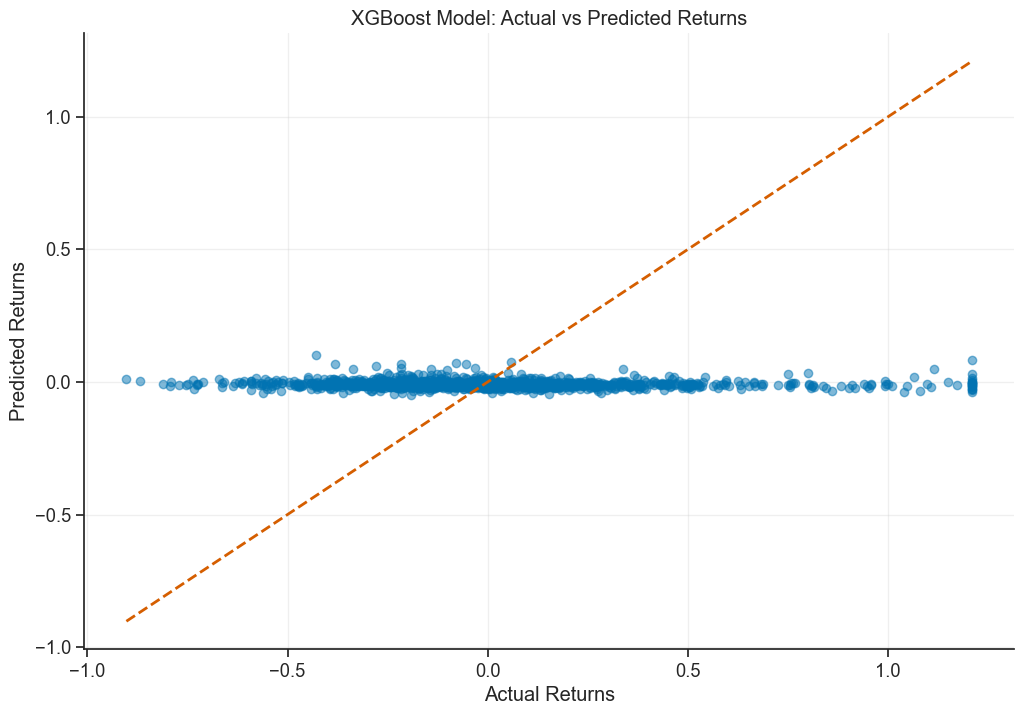

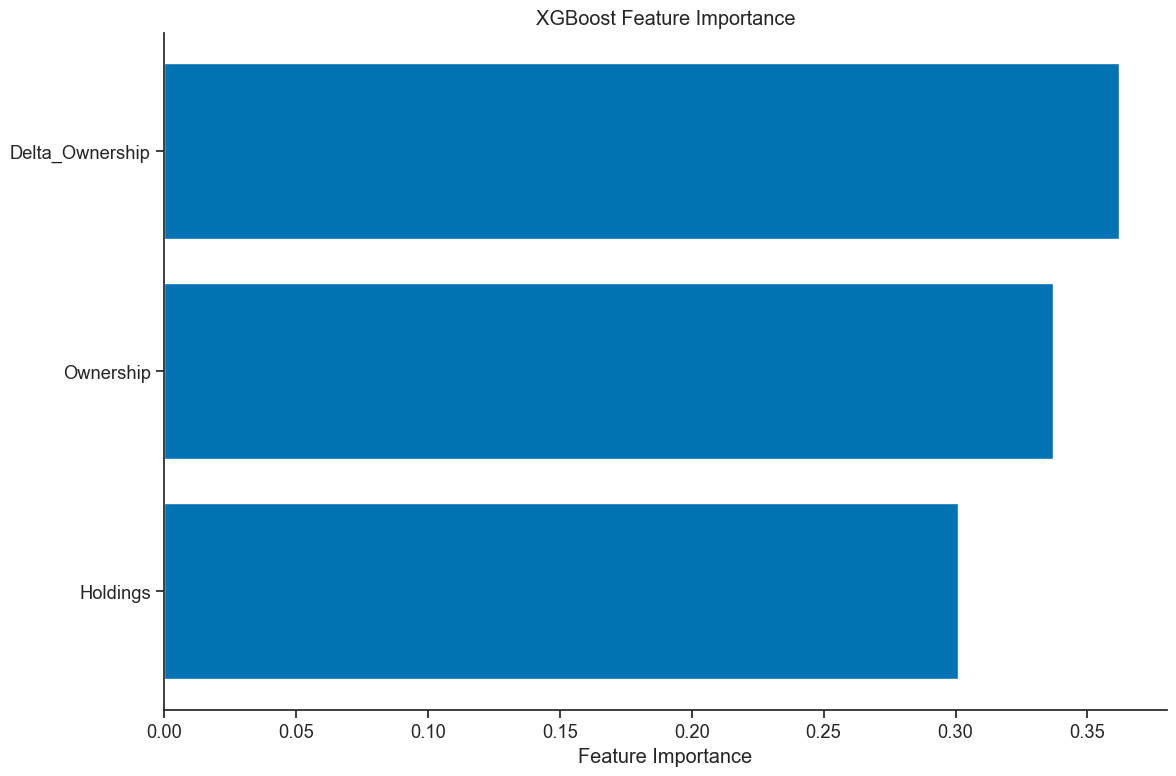

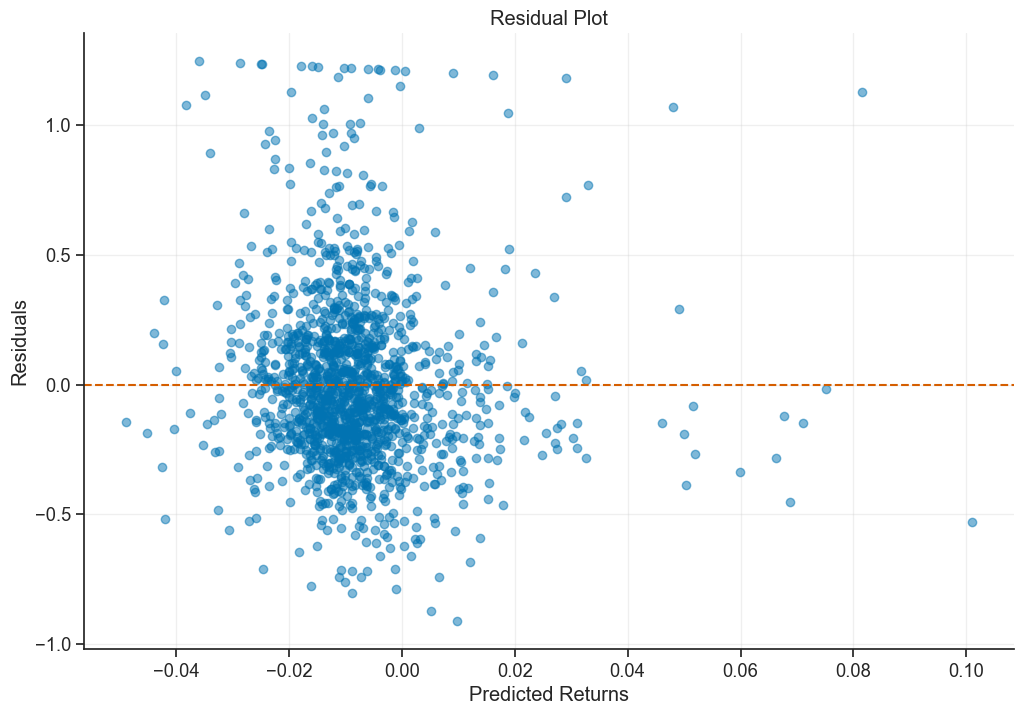

In [473]:
# Create a 2D plot to visualize the relationship between holdings, ownership, and delta_ownership with returns as color
# and use XGBoost Regression to predict returns based on holdings, ownership, and delta_ownership

# Lag the returns backwards one period before stacking
lagged_returns = quarter_end_returns.shift(-1)  # Shift backwards one period

# Since we already know holdings_df, ownership_df, delta_ownership, and lagged_returns have the same index and columns,
# we can directly stack them to create Series
stacked_holdings = holdings_df.stack()
stacked_ownership = ownership_df.stack()
stacked_delta_ownership = delta_ownership.stack()
stacked_returns = lagged_returns.stack()

# Create a DataFrame from the stacked Series
scatter_df = pd.DataFrame({
    'Holdings': stacked_holdings,
    'Ownership': stacked_ownership,
    'Delta_Ownership': stacked_delta_ownership,
    'Returns': stacked_returns
})

# Remove any rows with NaN values or holdings less than 0.001
scatter_df = scatter_df[scatter_df['Holdings'] >= 0.001]
scatter_df = scatter_df.dropna()

# Winsorize returns to +/- 3 standard deviations
returns_mean = scatter_df['Returns'].mean()
returns_std = scatter_df['Returns'].std()
lower_bound = returns_mean - 3 * returns_std
upper_bound = returns_mean + 3 * returns_std

# Apply winsorization
scatter_df['Returns'] = scatter_df['Returns'].clip(lower=lower_bound, upper=upper_bound)

# Import necessary libraries for plotting and modeling
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare data for modeling
X = scatter_df[['Holdings', 'Ownership', 'Delta_Ownership']]
y = scatter_df['Returns']

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Create a 5-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store performance metrics
mse_scores = []
r2_scores = []
fold_predictions = []

# XGBoost parameters as specified
xgb_params = {
    'learning_rate': 0.01,
    'n_estimators': 50,
    'max_depth': 4,
    'min_child_weight': 10,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Perform 5-fold cross-validation with XGBoost Regression
for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled_df)):
    X_train, X_test = X_scaled_df.iloc[train_idx], X_scaled_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train XGBoost model with specified parameters
    xgb_model = xgb.XGBRegressor(**xgb_params)
    
    # Fit model with error handling
    try:
        xgb_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = xgb_model.predict(X_test)
        
        # Handle any potential NaN or infinite values in predictions
        y_pred = np.nan_to_num(y_pred, nan=y_train.mean())
    except Exception as e:
        print(f"Error in fold training/prediction: {e}")
        # Fallback to mean prediction if model fails
        y_pred = np.full(len(X_test), y_train.mean())
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    mse_scores.append(mse)
    r2_scores.append(r2)
    fold_predictions.append((test_idx, y_pred))

# Train a final model on all data for visualization
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_scaled_df, y)

# Print average performance metrics
print(f"Average MSE across folds: {np.mean(mse_scores):.4f} (±{np.std(mse_scores):.4f})")
print(f"Print actual MSE: {mean_squared_error(y, final_model.predict(X_scaled_df)):.4f}")
print(f"MSE of mean prediction: {mean_squared_error(y, np.full_like(y, y.mean())):.4f}")
print(f"Average R² across folds: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")

# Combine all fold predictions for evaluation
all_indices = []
all_predictions = []
for indices, preds in fold_predictions:
    all_indices.extend(indices)
    all_predictions.extend(preds)

# Create a DataFrame with actual vs predicted values
results_df = pd.DataFrame({
    'Actual': y.iloc[all_indices].values,
    'Predicted': all_predictions
})

# Plot actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], 
         [results_df['Actual'].min(), results_df['Actual'].max()], 
         'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('XGBoost Model: Actual vs Predicted Returns')
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance plot
plt.figure(figsize=(12, 8))
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_scaled_df.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Residual plot
results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Predicted'], results_df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Returns')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.show()


In [474]:
print(r2_scores)

[-0.011207932483113137, -0.005053269946377892, -0.0016219882944052966, -0.006751128342890711, -0.008710113236576555]
